<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Monday 08 July 2019</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/amazon_fires/tree/EGU2020">github.com/douglask3/amazon_fires/tree/EGU2020</td>
</tr>
</table>
6Department of Biological Sciences, Macquarie University, North Ryde, Australia
<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of a global fire limitation model using Bayesian inference</h1>
<h2>Part 3: Posterior sampling</h2>
<br>
<br>
<sup>1,* </sup> Douglas Ian Kelley,
<sup>2 </sup>Chantelle Burton, 
<sup>3 </sup>Rhys Whitley,
<sup>1 </sup>Chris Huntingford,
<sup>4 </sup>Ioannis Bistinas, 
<sup>1,5 </sup>Megan Brown, 
<sup>6 </sup>Ning Dong, 
<sup>1 </sup>Toby R. Marthews
<br>
<br>
<br>
<sup>*  </sup> douglas.i.kelley@gmail.com
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>4 </sup>ATOS Nederland B.V., Amstelveen, The Netherlands
<br>
<sup>5 </sup>School of Physical Sciences, The Open University, Milton Keynes, UK
<br>
<sup>6 </sup>Department of Biological Sciences, Macquarie University, North Ryde, NSW 2109, Australia 
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
The previous notebook quantified the probability distribution of the model parameters of our global fire model. Here, we sample this distribution to obtain a number of key measures of fire regime: burnt area, and the limitation and sensitivity of fuel, moisture, ignitions and suppression controls.
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

# Load libraries

In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import lognorm

## Input information

Modify 'title_output' and you'll also need to mannually mkdir of the title_output in respective 'figures' folder. You can change which input are used to put into the model by changing the file dictionaries.
JULES data only runs from July 2000 to Dec 2010, so I created a separate dictionary for that (below). If you use this, you'll also have to change the output and figure directory.


Data in 'retrieved_codes/2000-2014' and 'jul2000-2014' has already been scaled and adjusted (e.g. lightning, RH).
The jul2000-2014 files have 168 time points and start at July 2000 and go up to June 2014, like the obs files. This makes them compatible when mixing up obs + UKESM runs.

In [2]:
dir = '../inputs/amazon_region/'

files = {'soilwMax'           : 'vegetation/MaxOverMean_soilw.0-10cm.gauss.2001-2019.nc',
         'shallow_soilw'      : 'climate/shallow_soilw.0-10cm.gauss.2001-2019.nc',
         'deep_soilw'         : 'climate/deep_soilw.10-200cm.gauss.2001-2019.nc',
         'precip'             : 'climate/precip2001-2019.nc',
         'emc'                : 'climate/emc-2001-2019.nc',
         'treeCover'          : 'vegetation/treecover-2001-June2018.nc',
         'lightning'          : 'climate/lightning2001-2019.nc',
         'pasture'            : 'human/pasture2001-2019.nc',
         'population_density' : 'human/population_density-PD_HYDEv3.2_2001-2018.nc',
         'cropland'           : 'human/cropland2001-2019.nc',
         'vegcover'           : 'vegetation/vegcover-2001-June2018.nc',
         'burnt_area'         : 'fire_counts/burnt_area_MCD64A1.006.nc'}


In [3]:
param_file = '../outputs/params-for_sampling.csv'

title_output = 'constant_post_2018_full_2002_BG2020'
fire_Season = [8]

Open data. The model takes data in the same dict class as above.

In [4]:
##open data
input_data = {}
for key, file in files.items():
    data = iris.load_cube(dir + file)
    input_data[key] = data

params = pd.read_csv(param_file)

We will recycle pervious years data for variables for which we do not have data for in 2019

In [5]:
ntime = max([dat.shape[0] for __, dat in input_data.items()])

ntime = 0 
for key, dat in input_data.items(): 
    if dat.shape[0] > ntime:
        ntime = dat.shape[0]
        temp = dat.copy()

for key, dat in input_data.items():
    ntime_d = dat.shape[0]
    if ntime_d < ntime:
        temp.data[0:ntime_d] = dat.data
        for mn in range(ntime_d, ntime):
            ntime_d_lastYr = mn - 12
            temp.data[mn] = temp.data[ntime_d_lastYr]
            
        input_data[key] = temp.copy()

Plotting annual averages just to make sure the data looks senible

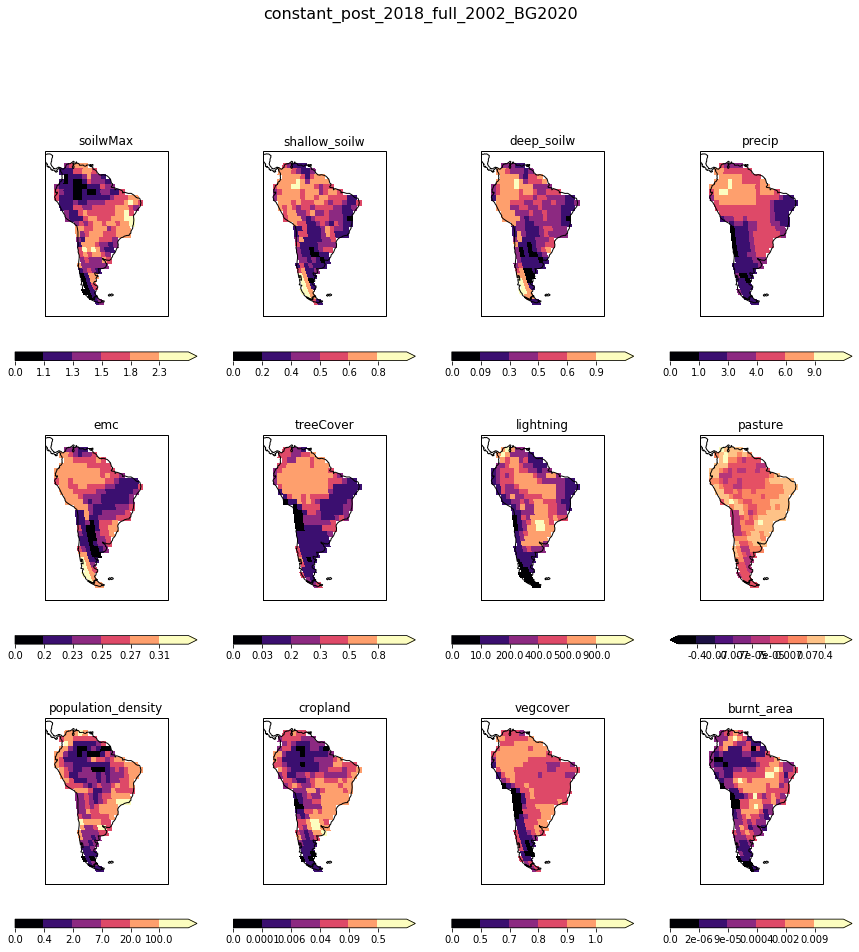

In [6]:
nd = 0

plt.figure(figsize = (15, 20))

for key, dat in input_data.items():
    nd = nd + 1
    dat = dat.collapsed('time', iris.analysis.MEAN)
    dat.long_name = key
    plot_lonely_cube(dat, 4, 4, nd, cmap = 'magma', levels = None)
    plt.suptitle(title_output, fontsize=16)
    plt.subplots_adjust(top=0.88)


## The model
The model is defined Kelley et al. 2019 and Kelley et al. submitted (available soon). See those for full model equations. Below, we define the model, this time as a class object on gridded temporal data and using ```np``` rather than ```tt```. This could be moved into a library at some point, but I've defined it here so you can have a proper look.

The model calculates a number of things needed to predict burnt area, and a few metric (potential limitation and sensitivity) on the fly. The things needed to calculate burnt area are ``ConFIRE.``:

* **Controls**:
    * ``fuel``: fuel continuity
    * ``moisture``: fuel mositure content
    * ``ignitions``: potential ignitions
    * ``suppression``: human fire suppression and landscape fragmentation

* **Limitation from controls**, the maximum allowed fire considering limitation from:
    * ``standard_fuel``:  fuel
    * ``standard_moisture``:  moisture
    * ``standard_ignitions``:  ignitions
    * ``standard_suppression``:  suppression

* and ``burnt_area``: burnt area from all limitations

Things calculated on the fly are:

* **Potential limitation**, the increase in burnt area if limitation where removed from:
    * ``potential_fuel``:  fuel
    * ``potential_moisture``:  moisture
    * ``potential_ignitions``:  ignitions
    * ``potential_suppression``:  suppression

* **Sensitvity**, the rate of change in burnt area for a given control, relative to the maximum possible rate of change for that controls:
    * ``sensitivity_fuel``:  fuel
    * ``sensitivity_moisture``:  moisture
    * ``sensitivity_ignitions``:  ignitions
    * ``sensitivity_suppression``:  suppression

In [7]:
class ConFIRE(object):
    def __init__(self, data, params):
        """
        Initalise parameters and calculates the key variables needed to calculate burnt area.
        """
        self.params = params


        ## finds controls
        self.fuel = self.control_fuel(data['vegcover'], data['soilwMax'], self.params['fuel_pw'],
                                      self.params['fuel_pg'])
        
        self.emcw = self.emc_weighted(data['emc'], data["precip"], self.params['wd_pg'])
        
        self.moisture = self.control_moisture(data['shallow_soilw'], data['deep_soilw'],
                                              self.emcw, data['treeCover'],
                                              self.params['cMs'], self.params['cM'], self.params['cMT'], 
                                              self.params['kM'])

        self.ignitions = self.control_ignitions(data['lightning'], data['pasture'], data['population_density'],
                                              self.params['cP'], self.params['cD1'])

        self.suppression = self.control_suppression(data['cropland'], data['population_density'],
                                              self.params['cD2'])

        ## calculates limiting factor of each control.
        self.standard_fuel        = self.sigmoid(self.fuel       ,
                                            self.params[       'fuel_x0'], self.params[       'fuel_k'])  
        
        self.standard_moisture    = self.sigmoid(self.moisture   ,
                                            self.params[   'moisture_x0'], -self.params[   'moisture_k'])
        self.standard_ignitions   = self.sigmoid(self.ignitions   ,
                                            self.params[  'ignition_x0'], self.params[  'ignition_k'])
        self.standard_suppression = self.sigmoid(self.suppression,
                                            self.params['suppression_x0'], -self.params['suppression_k'])

        ## burnt area us just limitation of each control muliplied together.
        self.burnt_area = self.standard_fuel * self.standard_moisture * self.standard_ignitions * \
        self.standard_suppression * self.params['max_f']# * (1.0 - self.params['p'])

        
        self.burnt_area.data =  -(1/self.params['exp_scale']) * np.log(1 - self.burnt_area.data) 
        
        self.standard_moisture    = self.standard_moisture    / self.sigmoid(0.0, self.params['moisture_x0'],
                                                 -self.params['moisture_k'])
        self.standard_suppression = self.standard_suppression / self.sigmoid(0.0, self.params['suppression_x0'],
                                                 -self.params['suppression_k'])
        
        self.error = self.params['sigma']
        try: 
            self.alpha_skew = self.params['alpha_skew']
        except:
            pass

        ## if the inputs are iris cubes, we can add some useful metadata
        try:
            self.burnt_area.long_name = "burnt_area"

            self.fuel.long_name = "fuel continuity"
            self.fuel.units = '1'

            self.moisture.long_name = "moisture content"
            self.moisture.units = '1'

            self.ignitions.long_name = "ignitions"
            self.ignitions.units = 'km-2'

            self.suppression.long_name = "suppression"
            self.suppression.units = '1'

            self.standard_fuel.long_name = "standard_fuel"
            self.standard_moisture.long_name = "standard_moisture"
            self.standard_ignitions.long_name = "standard_ignitions"
            self.standard_suppression.long_name = "standard_suppression"

            self.standard_fuel.units = '1'
            self.standard_moisture.units = '1'
            self.standard_ignitions.units = '1'
            self.standard_suppression.units = '1'
        except:
            pass

    #def burnt_area_error(self):
        
    
    def control_fuel(self, vegcover, alphaMax, fuel_pw, fuel_pg):
        """
        Definition to describe fuel load: while return the input; capability to be modified later.
        """
        return (vegcover**(fuel_pw+1)) * (fuel_pg * (alphaMax-1) + 1) / (1 + fuel_pg)
    
    def emc_weighted(self, emc, precip, wd_pg):
        try:
            wet_days = 1 - np.exp(-wd_pg * precip)
            emcw = wet_days + (1-wet_days) * emc
        except:
            emcw = emc.copy()
            emcw.data  = 1 - np.exp(-wd_pg * precip.data)
            emcw.data = emcw.data + (1-emcw.data) * emc.data
        return(emcw)

    def control_moisture(self, shallow_soil, deeps_soil, emc, treeCover, cMs, cM, cMT, kM):
        """
        Definition to describe moisture
        """
        moist = (shallow_soil + cMs * deeps_soil + cM*emc + cMT * treeCover) / (1 + cMs + cM + cMT)
        moist.data = 1 - np.log(1 - moist.data*kM)
        return moist


    def control_ignitions(self, lightning, pasture, population_density, cP, cD1):
        """
        Definition for the measure of ignition
        """
        ignite = lightning + cP*pasture + cD1*population_density
        
        return ignite


    def control_suppression(self, cropland, population_density, cD2):
        """
        Definition for the measure of fire supression
        """
        return cropland + cD2*population_density

        """
        Defines potential limitation for each control in turn
        """
    def potential_fuel(self):
        return self.potential(self.standard_fuel, "potential_fuel")


    def potential_moisture(self):
        return self.potential(self.standard_moisture, "potential_moisture")


    def potential_ignitions(self):
        return self.potential(self.standard_ignitions, "potential_ignitions")


    def potential_suppression(self):
        return self.potential(self.standard_suppression, "potential_suppression")


    def sensitivity_fuel(self):
        return self.sensitivity(self.fuel, self.params['fuel_x0'], self.params['fuel_k'],
                                self.standard_fuel, "sensitivity_fuel")

    """
    Defines sensitivity for each control in turn
    """
    def sensitivity_moisture(self):
        return self.sensitivity(self.moisture, self.params['moisture_x0'], -self.params['moisture_k'],
                                self.standard_moisture, "sensitivity_moisture")


    def sensitivity_ignitions(self):
        return self.sensitivity(self.ignitions, self.params['ignition_x0'], self.params['ignition_k'],
                                self.standard_ignitions, "sensitivity_ignitions")


    def sensitivity_suppression(self):
        return self.sensitivity(self.suppression, self.params['suppression_x0'], -self.params['suppression_k'] ,
                                self.standard_suppression, "sensitivity_suppression")


    def sensitivity(self, x, x0, k, fi, long_name = None):

        gradient = self.gradient(x, x0, k)
        sens = gradient * self.control_removal(fi)

        try: sens.units = '1'
        except: pass

        if long_name is not None:
            try: sens.long_name = long_name
            except: pass
        return sens


    def control_removal(self, fi):
        return self.burnt_area/fi


    def potential(self, fi, long_name = None):
        out = fi.copy()
        out.data = self.burnt_area.data * ((1/out.data) - 1)

        try: out.units = '1'
        except: pass

        if long_name is not None:
            try: out.long_name = long_name
            except: pass
        return out


    def gradient(self, x, x0, k, dx = 0.0001):

        f1 = self.sigmoid(x + dx, x0, k)
        f2 = self.sigmoid(x - dx, x0, k)

        n1 = self.sigmoid(x0 + dx, x0, k)
        n2 = self.sigmoid(x0 - dx, x0, k)

        try:
            f1 = (f1 - f2)/(n1 - n2)
        except:
            f1.data = (f1.data - f2.data) / (n1.data - n2.data)

        return f1


    def sigmoid(self, x, x0,k):
        """
        Sigmoid function to describe limitation using tensor
        """
        try:
            out = x.copy()
            out.data = -k*(x.data - x0)
            out.data = 1.0/(1.0 + np.exp(out.data))
            x = out
        except:
            x = -k * (x - x0)
            x = 1.0/(1.0 + np.exp(x))
        return x

#### Check that everything is working okay
Here, we run the model with the minium error spread and plot each of the outputs mentioned above to make sure everything is happy

In [8]:
# We're using the row which has minimum sigma

model = ConFIRE(input_data, params.loc[params["sigma"].idxmin()])

### Plotting

#### Fire measure

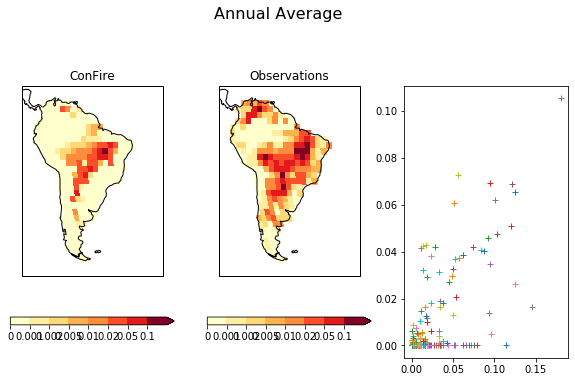

In [9]:
def plot_model_burnt_area(model, level, mnths = None, nmth_ys = 12,
                          figsize = (10, 11), Title = "Annual Average ", N = 2, M = 3, n = 0, 
                          addScatter = False, *args, **kw):
    if figsize is not None: plt.figure(figsize = figsize)
    if mnths is None: mnths = np.arange(0, 12*15)
    
    sim = model.burnt_area[mnths].collapsed('time', iris.analysis.MEAN)
    
    sim.long_name = "ConFire"
    sim.data = sim.data * nmth_ys

    plot_lonely_cube(sim, N, M, n + 1, levels = level, cmap = "brewer_YlOrRd_09", *args, **kw)

    obs = input_data["burnt_area"][mnths].collapsed('time', iris.analysis.MEAN)*nmth_ys
    obs.long_name = "Observations"
    plot_lonely_cube(obs, N, M, n + 2, levels = level, cmap = "brewer_YlOrRd_09", *args, **kw)
    
    if addScatter:
        plt.subplot(N, M, n + 3)
        plt.plot(obs.data, sim.data, '+')
    plt.subplots_adjust(top=0.88)
    plt.suptitle(Title, fontsize=16)
    plt.subplots_adjust(top=0.88)

            
clevels = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]


def plot_fire_month(*args, **kw):     
    plot_model_burnt_area(model, clevels, extend = 'max', *args, **kw)
            
plot_fire_month(addScatter = True)

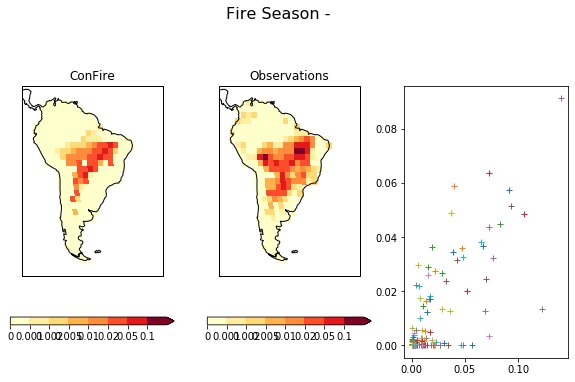

In [10]:
fire_Season = np.array([6,7,8])
fire_Seasons = np.array([fire_Season + yr*12 for yr in range(0, 19)])
fire_Season = fire_Seasons[0:15].flatten()
    
plot_fire_month(fire_Season, 3, Title = "Fire Season - ", addScatter = True)

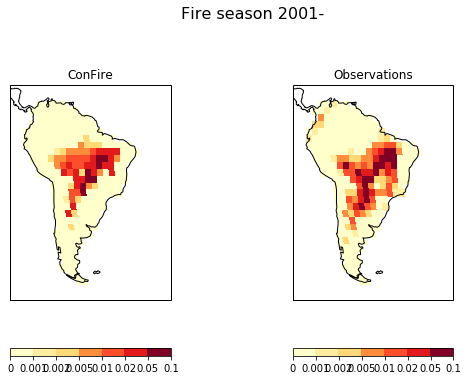

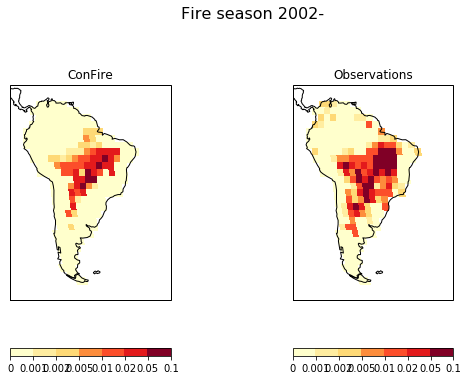

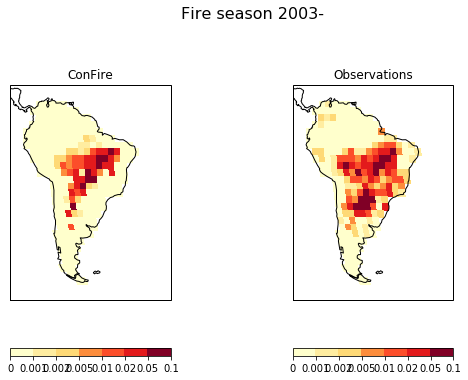

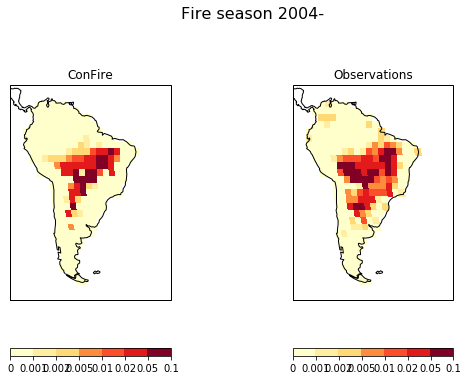

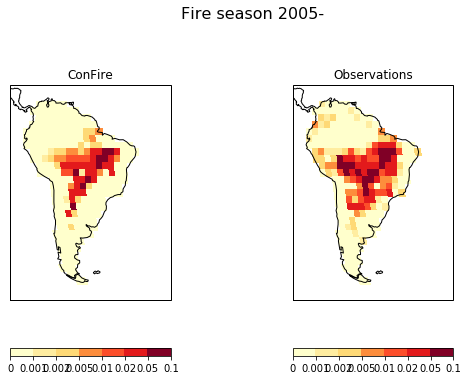

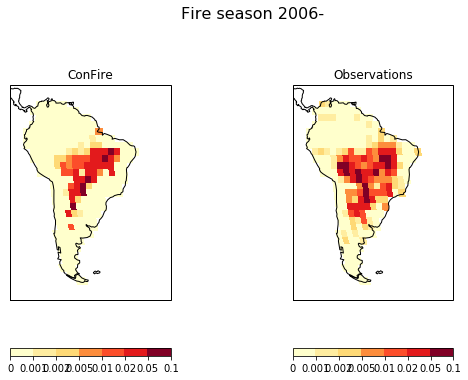

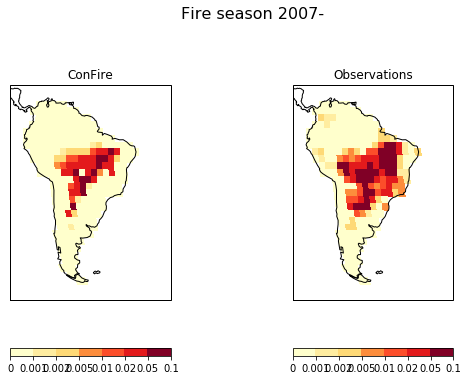

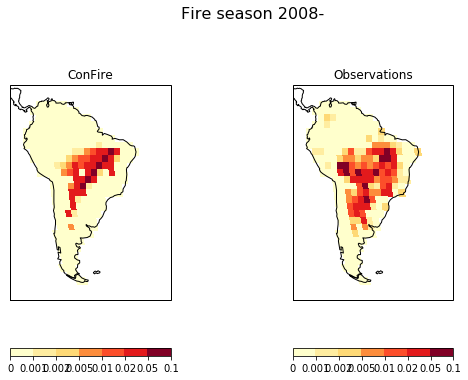

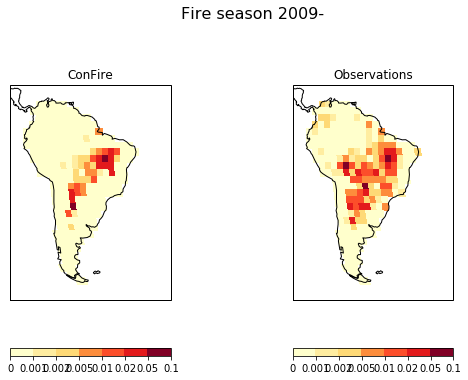

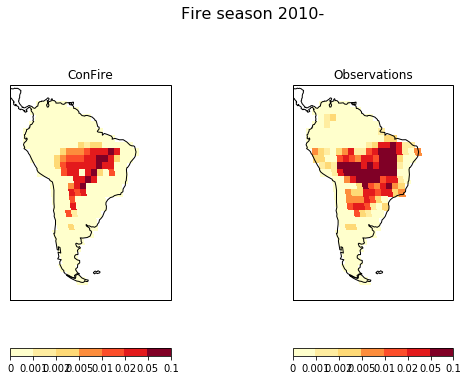

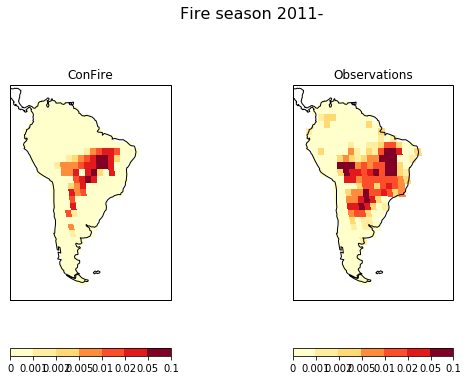

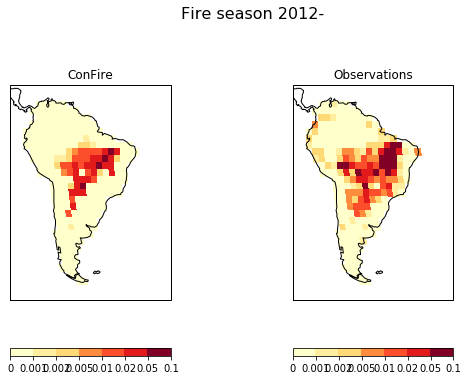

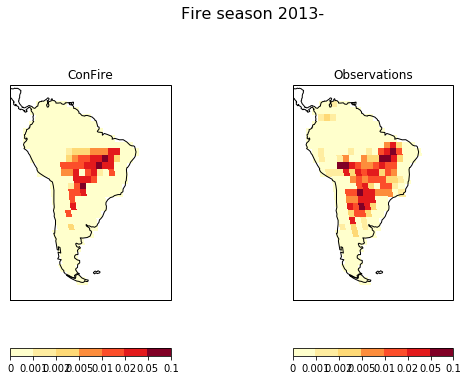

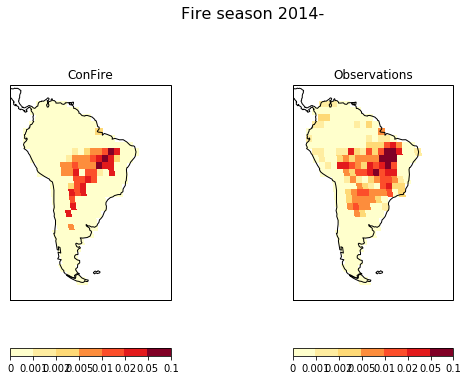

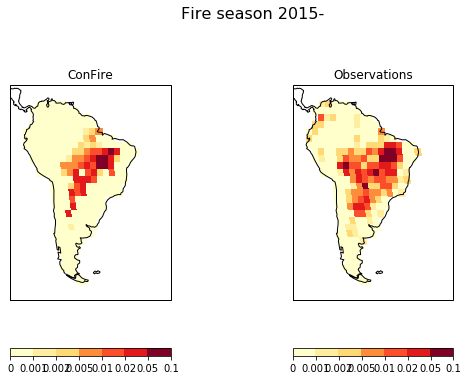

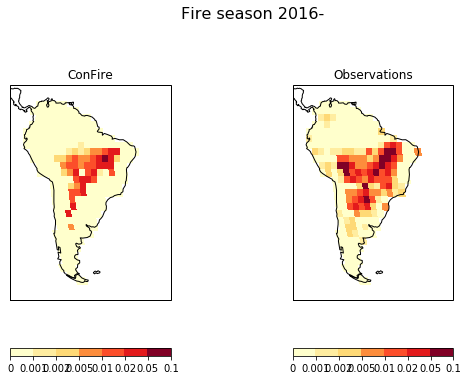

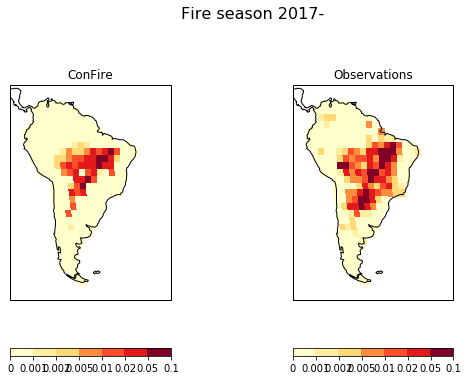

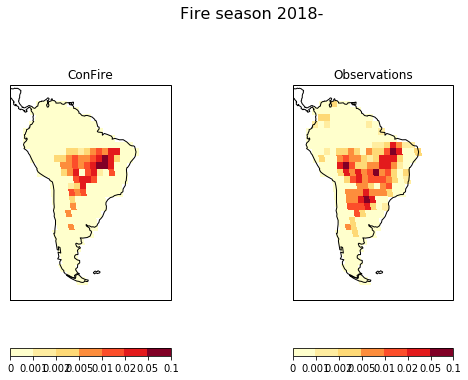

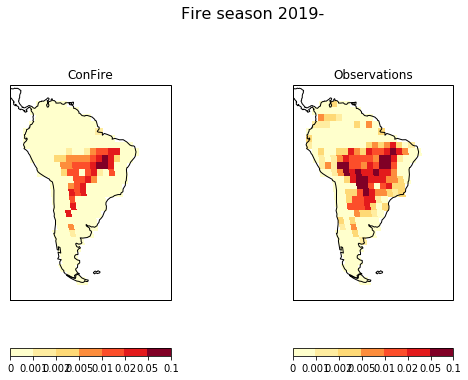

In [22]:
for yr, season in zip(range(0, 19), fire_Seasons):
    plt.figure(figsize = (8, 10))
    plot_model_burnt_area(model, clevels, mnths = season, nmth_ys = 3,
                          Title = "Fire season " + str(yr + 2001) + '-',
                          figsize = None, M = 2, n = 0)
    plt.show()

#### Controls

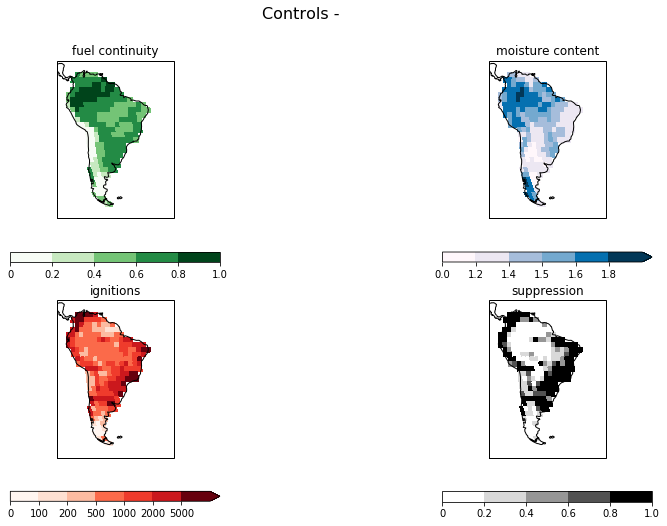

In [23]:
cmap_fuel = 'brewer_Greens_09'
cmap_moisture = 'brewer_PuBu_09'
cmap_ignitions = 'brewer_Reds_09'
cmap_suppression = 'brewer_Greys_09'

levels_frac = [0,0.2, 0.4, 0.6,  0.8,  1.0]
#levels_frac = [0,0.45,  0.5, 0.55, 1.0]
levels_ignitions = [0, 100, 200,500, 1000, 2000, 5000]
levels_moisture = [0, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    
def plotModComponet(comp, n, mnths = None, name = None, levels = None, scale = None, cmap = "brewer_YlOrRd_09",
                    N = 2, M = 2, *args, **kws):
    if mnths is None: mnths = np.arange(0, 12*15)
    
    comp = comp[mnths].collapsed('time', iris.analysis.MEAN)
    if scale is not None: comp.data = comp.data * scale
    if name  is not None: comp.long_name = name
    plot_lonely_cube(comp, N, M, n, levels = levels, cmap = cmap, *args, **kws)

def plot_fire_month(Title = '',  **kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.fuel, 1, cmap = cmap_fuel, levels = levels_frac, **kw)
    plotModComponet(model.moisture, 2, cmap = cmap_moisture, levels = None, extend = 'max', **kw)
    plotModComponet(model.ignitions, 3, cmap = cmap_ignitions, levels = levels_ignitions, extend = 'max', **kw)
    plotModComponet(model.suppression, 4, cmap = cmap_suppression, levels = levels_frac, **kw)
    plt.suptitle('Controls - ' + Title, fontsize=16)
    plt.subplots_adjust(top=0.88)
    
            
plot_fire_month()

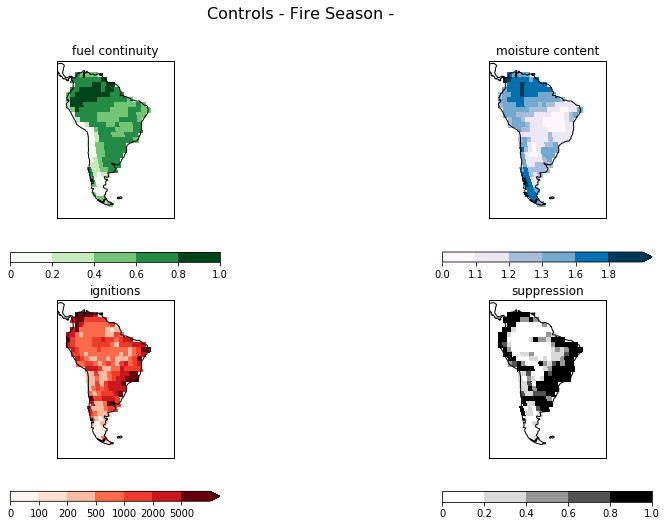

In [24]:
plot_fire_month('Fire Season - ', mnths = fire_Season)

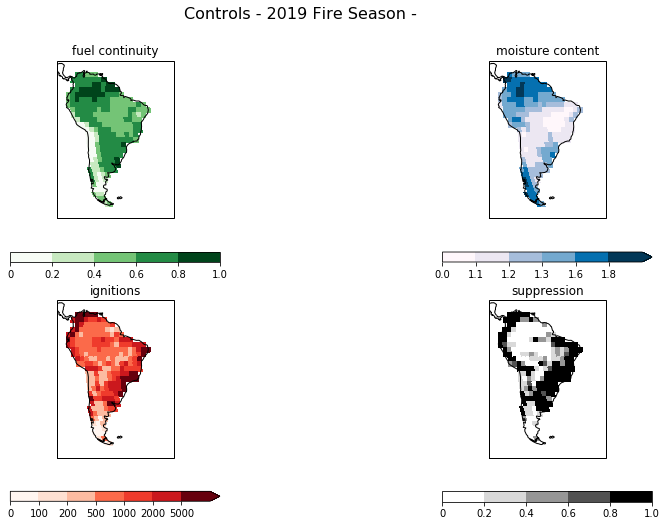

In [25]:
plot_fire_month('2019 Fire Season - ', mnths = np.array([6, 7, 8]) + 12 * 17)

#### Standard Limitation

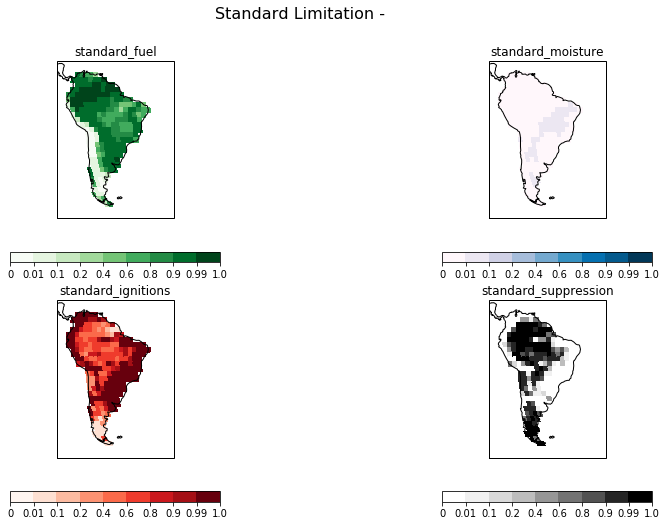

In [26]:
levels = [0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0]
def plot_fire_month(**kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.standard_fuel, 1, cmap = cmap_fuel, levels = levels, **kw)
    plotModComponet(model.standard_moisture, 2, cmap = cmap_moisture, levels = levels, **kw)
    plotModComponet(model.standard_ignitions, 3, cmap = cmap_ignitions, levels = levels, **kw)
    plotModComponet(model.standard_suppression, 4, cmap = cmap_suppression, levels = levels, **kw)
    plt.suptitle('Standard Limitation - ', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month()

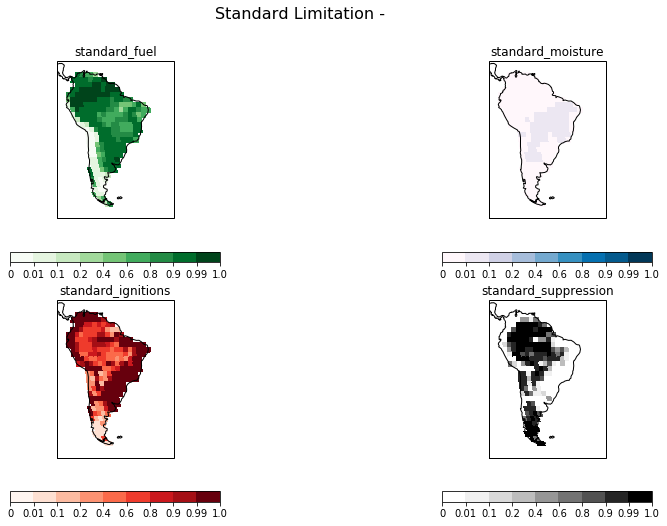

In [27]:
plot_fire_month(mnths = fire_Season)

#### Potential limitation

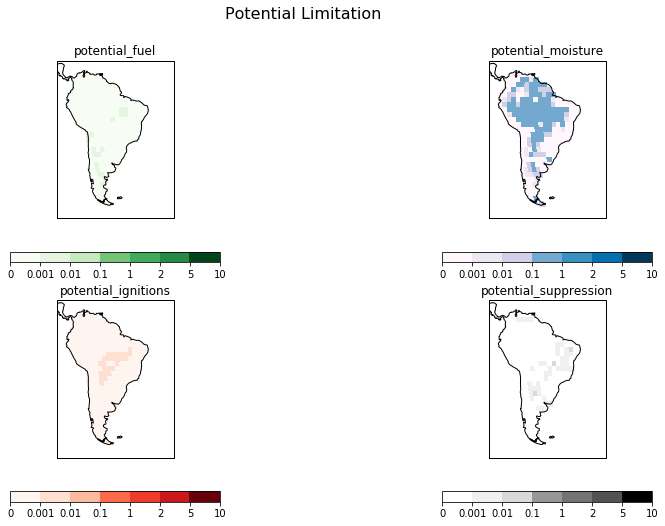

In [28]:
levels = [0, 0.001, 0.01, 0.1, 1, 2, 5, 10]
def plot_fire_month(**kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.potential_fuel(), 1, levels = levels,
                    cmap = cmap_fuel, **kw)
    plotModComponet(model.potential_moisture(), 2, levels = levels,
                    cmap = cmap_moisture, **kw)
    plotModComponet(model.potential_ignitions(), 3, levels = levels,
                    cmap = cmap_ignitions, **kw)
    plotModComponet(model.potential_suppression(), 4, levels = levels,
                    cmap = cmap_suppression, **kw)
    plt.suptitle('Potential Limitation', fontsize=16)
    plt.subplots_adjust(top=0.88)

plot_fire_month()

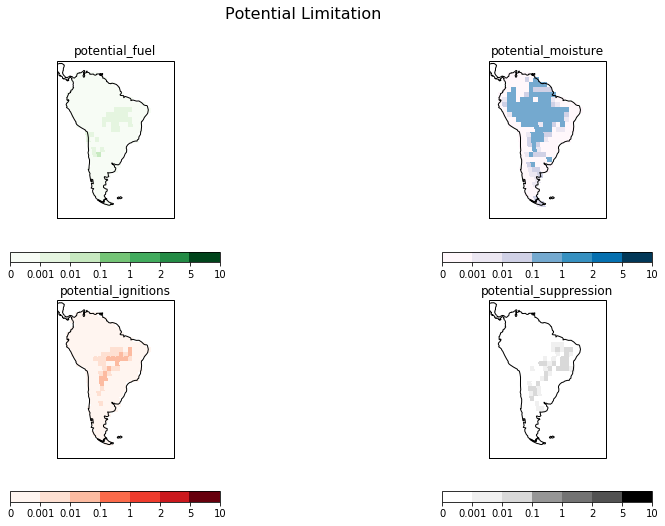

In [29]:
plot_fire_month(mnths = fire_Season)

#### Sensitivty

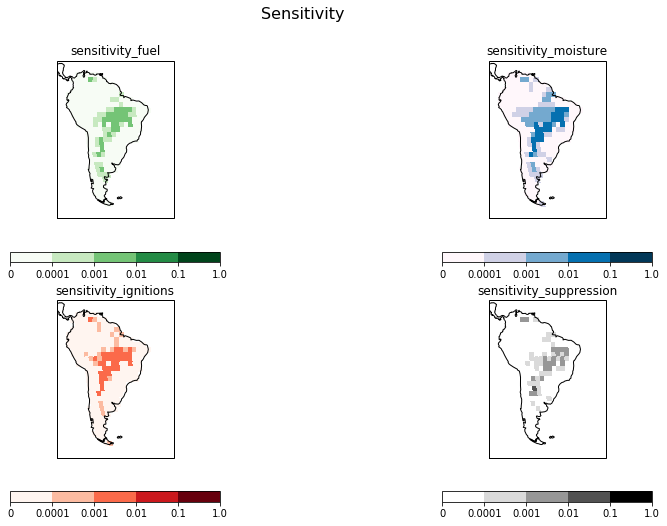

In [30]:
levels = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]
def plot_fire_month(**kw):
    plt.figure(figsize = (10, 7.5))
        
    plotModComponet(model.sensitivity_fuel(), 1, levels = levels,
                    cmap = cmap_fuel)
    plotModComponet(model.sensitivity_moisture(), 2, levels = levels,
                    cmap = cmap_moisture)
    plotModComponet(model.sensitivity_ignitions(), 3, levels = levels,
                    cmap = cmap_ignitions)
    plotModComponet(model.sensitivity_suppression(), 4, levels = levels,
                    cmap = "Greys")
    plt.suptitle('Sensitivity', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month()

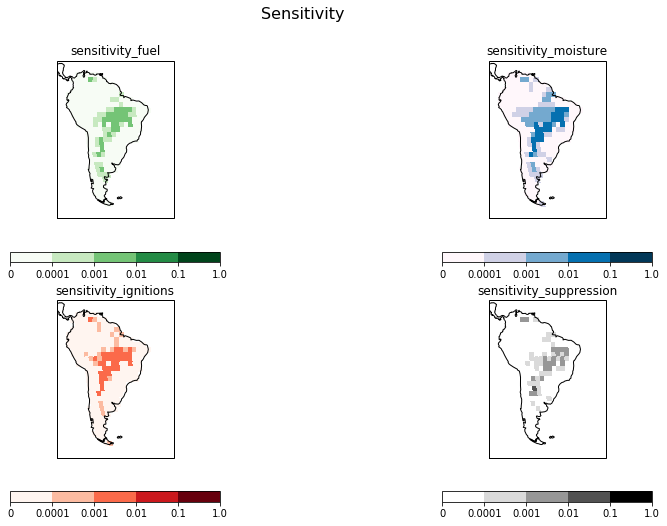

In [31]:
plot_fire_month(mnth = fire_Season)

### Bootstrapping Postieor
So, thats all been looking at just one, albiet very likely parameter combination. The really useful thing about this framework is the uncertainty in the parameters. I'll probably add some visulaisation of that here at some point, but the main thing is to sample the postiror so you can go away and do you own analysis. 

First off some switches. Which things do you want to get a sample for?:

* ```output_controls``` for fuel, moistire, igntions and sepression
* ```output_<<<xxx>>``` output the <<xxx>> type of limitation or sensitivity.

The more you have switched on, the long it takes. But the more cool results you'll have!

In [32]:
output_controls = True
output_standard_limitation = True
output_potential_limitation = True
output_sensitivity = True

Next we have the number of parameter combinations we want to sample (```n_posterior_sample```) - the more the better detail but the longer the time. ```step``` is descibed the sampling gap for the paramater combination + error. The unit is fractional burnt area. The small the step, the more detailed you overall postiror (i.e P(fire| (B | Obs)), but the slower. You might not need P(fire| (B | Obs). In which case, set this to ```None``` and enjoy the extra quick processing time!

```qs``` is the percentiles we'll use to summerise the prbablity density curves at the end. I just set this to 1-99% at 1% intervals... might be overkill (maybe you just need 1, 5, 10, 25, 50, 75, 90, 95, 99 for example). But its so quick compared to everything else, that I'd rather set this detailed so I dont have to rerun.

Finally, we set a directory to stick a load of outputs we're about to generate

In [33]:
n_posterior_sample = 1000
step = 0.001

qs = np.arange(1, 100, 1)
output_dir = '../outputs/sampled_posterior_ConFire_solutions/'

Now lets do some sampling.... I still need to comment through this. Watch this space....

In [34]:
def newCubes(variable, step, eg_cube_in, dimname = 'model_level_number'):
    maxV = np.max(eg_cube_in.data)
    maxV = np.ceil(maxV) * 1.5
    def newCube(i):
        coord = iris.coords.AuxCoord(i, dimname)
        eg_cube = eg_cube_in.copy()
        eg_cube.data[eg_cube.data > 0.0] = 0.0
        try:
            eg_cube.remove_coord(dimname)
        except:
            pass
        eg_cube.add_aux_coord(coord)
        return(eg_cube)
    
    if not hasattr(step, '__len__'):
        step = np.arange(0,maxV, step) + step/2.0
        
    eg_cubes = iris.cube.CubeList([newCube(i) for i in step])
    eg_cubes = eg_cubes.merge()[0]
    return(eg_cubes)


In [35]:
def weighted_percentile(data, percents, weights=None):
    ''' percents in units of 1%
        weights specifies the frequency (count) of data.
    '''
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data[ind]
    w=weights[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

In [36]:
if step is not None:
    v = 'model_level_number'
    eg_cubes = newCubes('burnt_area', step, input_data['burnt_area'], v)
    level_no = eg_cubes.coord(v).points
        
n_posterior = params.shape[0]
ngap = int(n_posterior/n_posterior_sample)
if ngap == 0: ngap = 1

try: os.mkdir(output_dir)
except: pass

output_dir = output_dir + title_output +'/'
try: os.mkdir(output_dir)
except: pass

In [ ]:
fire_outi = []
for i in range(0, n_posterior, ngap):

    model = ConFIRE(input_data, params.iloc[i])
    cubes = [model.burnt_area]

    if step is not None:
        mask = np.logical_not(model.burnt_area.data.mask)
        dist = norm(model.burnt_area.data[mask], model.error)
        
        for k in range(0, eg_cubes.shape[0]):
            eg_cubes.data[k][mask] += dist.pdf(k*step)

    if output_controls:
        cubes = cubes + [model.fuel, model.moisture, 
                         model.ignitions, model.suppression]

    if output_standard_limitation:
        cubes = cubes + [model.standard_fuel, model.standard_moisture, 
                         model.standard_ignitions, model.standard_suppression]

    if output_potential_limitation:
        cubes = cubes + [model.potential_fuel(), model.potential_moisture(),                 
                         model.potential_ignitions(), model.potential_suppression()]

    if output_sensitivity:
        cubes = cubes + [model.sensitivity_fuel(), model.sensitivity_moisture(),                  
                         model.sensitivity_ignitions(), model.sensitivity_suppression()]

    cubes = iris.cube.CubeList(cubes) 

    fire_outi = fire_outi + [cubes]
    outFile = output_dir + 'sample_no_' + str(i) +'.nc'
    print(outFile)
    iris.save(cubes, outFile)

../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_0.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_60.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_120.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_180.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_240.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_300.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_360.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_420.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_480.nc
../outputs/sampled_posterior_ConFire_solutions/constant_post_2018_full_2002_BG2020/sample_no_540.nc
../

In [ ]:
if step is not None:
    def cell_weighted_percentile(cell_in):
        cell = cell_in.data
        if cell[0] < 0: return(np.ones(len(qs)) * cell[0])

        out = weighted_percentile(level_no, qs, cell)
        if out[0] > out[-1]: browser()
        return(out)

    quatilesData = np.apply_along_axis(cell_weighted_percentile, 0, eg_cubes.data)

    percentile_cube = newCubes(variable, qs, eg_cubes[0]) 
    percentile_cube.data = np.ma.array(quatilesData, mask = percentile_cube.data.mask.copy())

    eg_cubes.long_name = variable + '_frequency_of_occurnace'
    #cubes_summ.standard_name = 'frequency_of_occurnace'
    percentile_cube.long_name = variable + '_at_percentile'
    outFile_summ = output_dir + 'fire_summary_'
    cubes_summ  = iris.cube.CubeList([percentile_cube]) 
    iris.save(cubes_summ, outFile_summ + 'precentile.nc')

    cubes_summ  = iris.cube.CubeList([eg_cubes]) 
    iris.save(cubes_summ, outFile_summ + 'frequancy_of_counts.nc')

fire_out = []
for i in range(len(fire_outi[0])):
    print(i)
    outi = []
    for out in fire_outi:
        outi = outi + [out[i].data]

    percentile_cube = newCubes(variable, qs, out[i]) 
    percentile_cube.data = np.percentile(np.array(outi), qs, 0)

    fire_out = fire_out + [percentile_cube]


outFile = output_dir + 'model_summary.nc'

fire_out = iris.cube.CubeList(fire_out) 
print(outFile)
iris.save(fire_out, outFile)

posterior_pos = input_data[variable].copy()
posterior_pos.data[posterior_pos.data > 0] = 0

posterior_p_value = posterior_pos.copy()
p_value_tester = posterior_pos.copy()

for k in range(eg_cubes.shape[0]):

    test = input_data[variable].data < (eg_cubes.coord("model_level_number").points[k] - step/2.0)
    posterior_pos.data[test] += eg_cubes[k].data[test]

    test = np.abs(input_data[variable].data - eg_cubes.coord("model_level_number").points[k]) <= step/2
    p_value_tester.data[test] = eg_cubes[k].data[test]

for k in range(eg_cubes.shape[0]):
    test = eg_cubes[k].data > p_value_tester.data
    posterior_p_value.data[test] += eg_cubes[k].data[test]

tot = eg_cubes.collapsed("model_level_number", iris.analysis.SUM)
posterior_pos.data /= tot.data
posterior_p_value.data /= tot.data

posterior_p_value.long_name = 'p_value'
posterior_pos.long_name = 'observed_posterior_position'

cubes_summ  = iris.cube.CubeList([posterior_p_value, posterior_pos]) 
iris.save(cubes_summ, outFile_summ + 'observed_liklihood.nc')